# Bert 

In [5]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import os

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directory for saving results
os.makedirs("visualization", exist_ok=True)


## Step 1: Data Loading

In [6]:
# Define NSL-KDD column names
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load dataset
train_df = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test_df = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop difficulty degree column (not needed)
train_df.drop("difficulty_degree", axis=1, inplace=True)
test_df.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to string representation
categorical_features = ["protocol_type", "service", "flag"]
for col in categorical_features:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# Convert labels into binary classification
train_df["labels"] = train_df["labels"].apply(lambda x: 1 if x == "normal" else 0)
test_df["labels"] = test_df["labels"].apply(lambda x: 1 if x == "normal" else 0)


In [7]:
# First, split train data into train/validation (STRATIFIED SPLIT to maintain class balance)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["labels"]
)

# Function to convert tabular data into text for NLP processing
def convert_to_text(row):
    return f"Duration: {row['duration']}, Protocol: {row['protocol_type']}, " \
           f"Service: {row['service']}, Flag: {row['flag']}, " \
           f"Src_Bytes: {row['src_bytes']}, Dst_Bytes: {row['dst_bytes']}, " \
           f"Count: {row['count']}, Serror_Rate: {row['serror_rate']}"

# Apply text conversion AFTER splitting
train_df["text_features"] = train_df.apply(convert_to_text, axis=1)
val_df["text_features"] = val_df.apply(convert_to_text, axis=1)
test_df["text_features"] = test_df.apply(convert_to_text, axis=1)


In [8]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_features = ["protocol_type", "service", "flag"]

# Apply Label Encoding to categorical variables
label_encoders = {}  # Store encoders for future transformations
for col in categorical_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])  # Fit on training data
    val_df[col] = le.transform(val_df[col])  # Transform validation set
    test_df[col] = le.transform(test_df[col])  # Transform test set
    label_encoders[col] = le  # Store encoder for inverse transformation if needed


In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE (excluding 'text_features' which is for BERT)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(
    train_df.drop(columns=["labels", "text_features"]),  # Only numeric features
    train_df["labels"]
)

# Convert back to DataFrame
train_df = pd.DataFrame(X_resampled, columns=train_df.drop(columns=["labels", "text_features"]).columns)
train_df["labels"] = y_resampled  # Restore labels

# Recreate text features for BERT processing
train_df["text_features"] = train_df.apply(convert_to_text, axis=1)


/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [10]:
df_majority = train_df[train_df["labels"] == 1]  # Normal traffic
df_minority = train_df[train_df["labels"] == 0]  # Attack traffic

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
train_df = pd.concat([df_majority_downsampled, df_minority])


In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert data to Hugging Face Dataset
train_data = Dataset.from_dict({"text": train_df["text_features"].tolist(), "label": train_df["labels"].tolist()})
val_data = Dataset.from_dict({"text": val_df["text_features"].tolist(), "label": val_df["labels"].tolist()})
test_data = Dataset.from_dict({"text": test_df["text_features"].tolist(), "label": test_df["labels"].tolist()})

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/107748 [00:00<?, ? examples/s]

Map:   0%|          | 0/25195 [00:00<?, ? examples/s]

Map:   0%|          | 0/22544 [00:00<?, ? examples/s]

In [12]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
).to(device)

training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer
)

trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
preds = trainer.predict(val_data)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = val_df["labels"].tolist()

probs = softmax(preds.predictions, axis=1)[:, 1]
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)


100%|██████████| 6299/6299 [05:03<00:00, 20.79it/s]


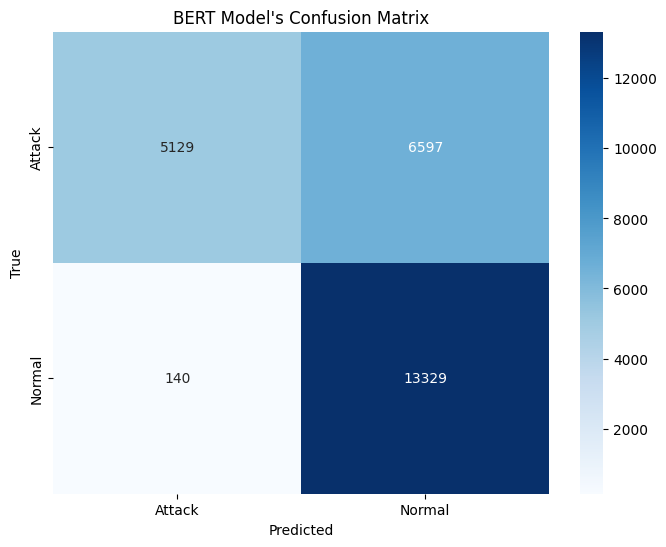

In [ ]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("BERT Model's Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("visualization/Bert_confusion_matrix.png")
plt.show()

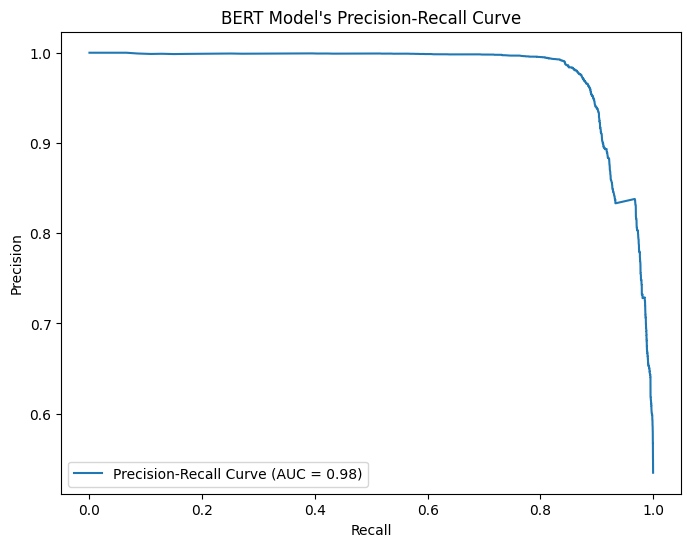

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("BERT Model's Precision-Recall Curve")
plt.legend()
plt.savefig("visualization/Bert_precision_recall_curve.png")  # Save to folder
plt.show()


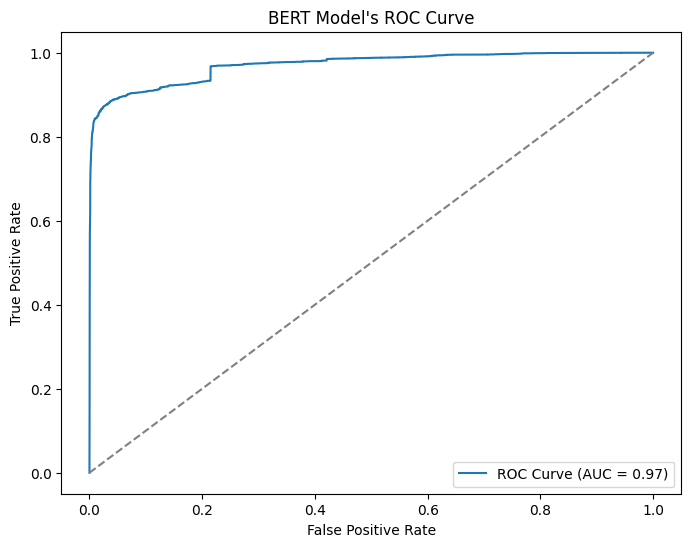

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BERT Model's ROC Curve")
plt.legend()
plt.savefig("visualization/Bert1_roc_curve.png")  # Save to folder
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate Classification Report
classification_report_text = classification_report(y_true, y_pred)

# Save to a text file
with open("visualization/Bert-classification_report.txt", "w") as f:
    f.write(classification_report_text)

# Print report
print(classification_report_text)


              precision    recall  f1-score   support

           0       0.97      0.44      0.60     11726
           1       0.67      0.99      0.80     13469

    accuracy                           0.73     25195
   macro avg       0.82      0.71      0.70     25195
weighted avg       0.81      0.73      0.71     25195

